# Character-level Language Modeling with LSTMs

This notebook is adapted from [Keras' lstm_text_generation.py](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py).

Steps:

- Download a small text corpus and preprocess it.
- Extract a character vocabulary and use it to vectorize the text.
- Train an LSTM-based character level langague model.
- Use the trained model to sample random text with varying entropy levels.
- Implement a beam-search deterministic decoder.


**Note**: fitting language models is very computation intensive. It is **recommended to do this notebook on a server with a GPU or powerful CPUs** that you can leave running for several hours at once.

In [46]:
!pip install watermark

In [47]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,matplotlib,nltk

Gopala KR 
last updated: 2018-03-04 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.14.1
matplotlib 2.1.2
nltk 3.2.5


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Loading some text data

Let's use some publicly available philosopy:

In [2]:
from keras.utils.data_utils import get_file

URL = "https://s3.amazonaws.com/text-datasets/nietzsche.txt"

corpus_path = get_file('nietzsche.txt', origin=URL)
text = open(corpus_path).read().lower()
print('Corpus length: %d characters' % len(text))

/srv/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


606208/600901 [==============================] - 0s 1us/step
Corpus length: 600893 characters


In [3]:
print(text[:600], "...")

preface


supposing that truth is a woman--what then? is there not ground
for suspecting that all philosophers, in so far as they have been
dogmatists, have failed to understand women--that the terrible
seriousness and clumsy importunity with which they have usually paid
their addresses to truth, have been unskilled and unseemly methods for
winning a woman? certainly she has never allowed herself to be won; and
at present every kind of dogma stands with sad and discouraged mien--if,
indeed, it stands at all! for there are scoffers who maintain that it
has fallen, that all dogma lies on the gro ...


In [4]:
text = text.replace("\n", " ")
split = int(0.9 * len(text))
train_text = text[:split]
test_text = text[split:]

## Building a vocabulary of all possible symbols 

To simplifly things, we build a vocabulary by extracting the list all possible characters from the full datasets (train and validation).

In a more realistic setting we would need to take into account that the test data can hold symbols never seen in the training set. This issue is limited when we work at the character level though.

Let's build the list of all possible characters and sort it to assign a unique integer to each possible symbol in the corpus:

In [5]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 56


`char_indices` is a mapping to from characters to integer identifiers:

In [6]:
len(char_indices)

56

In [7]:
sorted(char_indices.items())[:15]

[(' ', 0),
 ('!', 1),
 ('"', 2),
 ("'", 3),
 ('(', 4),
 (')', 5),
 (',', 6),
 ('-', 7),
 ('.', 8),
 ('0', 9),
 ('1', 10),
 ('2', 11),
 ('3', 12),
 ('4', 13),
 ('5', 14)]

`indices_char` holds the reverse mapping:

In [8]:
len(indices_char)

56

In [9]:
indices_char[52]

'ä'

While not strictly required to build a language model, it's a good idea to have a look a the distribution of relative frequencies of each symbol in the corpus:

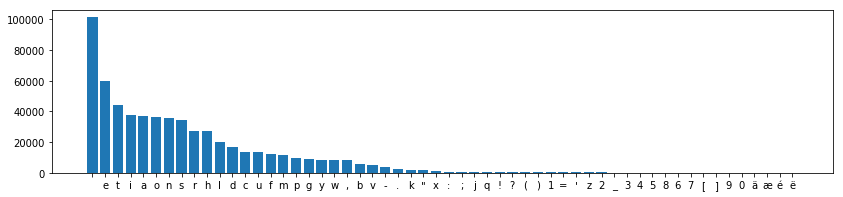

In [10]:
from collections import Counter

counter = Counter(text)
chars, counts = zip(*counter.most_common())
indices = np.arange(len(counts))

plt.figure(figsize=(14, 3))
plt.bar(indices, counts, 0.8)
plt.xticks(indices, chars);

Let's cut the dataset into fake sentences at random with some overlap. Instead of cutting at random we could use a English specific sentence tokenizer. This is explained at the end of this notebook. In the mean time random substring will be good enough to train a first language model.

In [11]:
max_length = 40
step = 3


def make_sequences(text, max_length=max_length, step=step):
    sequences = []
    next_chars = []
    for i in range(0, len(text) - max_length, step):
        sequences.append(text[i: i + max_length])
        next_chars.append(text[i + max_length])
    return sequences, next_chars    


sequences, next_chars = make_sequences(train_text)
sequences_test, next_chars_test = make_sequences(test_text, step=10)

print('nb train sequences:', len(sequences))
print('nb test sequences:', len(sequences_test))

nb train sequences: 180255
nb test sequences: 6005


Let's shuffle the sequences to break some of the dependencies:

In [12]:
from sklearn.utils import shuffle

sequences, next_chars = shuffle(sequences, next_chars,
                                random_state=42)

In [13]:
sequences[0]

'distrust, a refinement of distrust of ev'

In [14]:
next_chars[0]

'e'

## Converting the training data to one-hot vectors

Unfortunately the LSTM implementation in Keras does not (yet?) accept integer indices to slice columns from an input embedding by it-self. Let's use one-hot encoding. This is slightly less space and time efficient than integer coding but should be good enough when using a small character level vocabulary.

**Exercise:** 

One hot encoded the training `data sequences` as `X` and `next_chars` as `y`:

In [15]:
n_sequences = len(sequences)
n_sequences_test = len(sequences_test)
voc_size = len(chars)

X = np.zeros((n_sequences, max_length, voc_size),
             dtype=np.float32)
y = np.zeros((n_sequences, voc_size), dtype=np.float32)

X_test = np.zeros((n_sequences_test, max_length, voc_size),
                  dtype=np.float32)
y_test = np.zeros((n_sequences_test, voc_size), dtype=np.float32)

# TODO

In [16]:
# %load solutions/language_model_one_hot_data.py

In [17]:
X.shape

(180255, 40, 56)

In [18]:
y.shape

(180255, 56)

In [19]:
X[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

## Measuring per-character perplexity

The NLP community measures the quality of probabilistic model using [perplexity](https://en.wikipedia.org/wiki/Perplexity).

In practice perplexity is just a base 2 exponentiation of the average negative log2 likelihoods:

$$perplexity_\theta = 2^{-\frac{1}{n} \sum_{i=1}^{n} log_2 (p_\theta(x_i))}$$

**Note**: here we define the **per-character perplexity** (because our model naturally makes per-character predictions). **It is more common to report per-word perplexity**. Note that this is not as easy to compute the per-world perplexity as we would need to tokenize the strings into a sequence of words and discard whitespace and punctuation character predictions. In practice the whitespace character is the most frequent character by far making our naive per-character perplexity lower than it sould be if we ignored those.

**Exercise**: implement a Python function that computes the per-character perplexity with model predicted probabilities `y_pred` and `y_true` for the encoded ground truth:

In [21]:
def perplexity(y_true, y_pred):
    """Compute the per-character perplexity of model predictions.
    
    y_true is one-hot encoded ground truth.
    y_pred is predicted likelihoods for each class.
    
    2 ** -mean(log2(p))
    """
    # TODO
    return 1.

In [22]:
# %load solutions/language_model_perplexity.py

In [23]:
y_true = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1],
])

y_pred = np.array([
    [0.1, 0.9, 0.0],
    [0.1, 0.1, 0.8],
    [0.1, 0.2, 0.7],
])

perplexity(y_true, y_pred)

1.0

A perfect model has a minimal perplexity of 1.0 bit (negative log likelihood of 0.0):

In [24]:
perplexity(y_true, y_true)

1.0

## Building recurrent model

Let's build a first model and train it on a very small subset of the data to check that it works as expected:

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop


model = Sequential()
model.add(LSTM(128, input_shape=(max_length, voc_size)))
model.add(Dense(voc_size, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

Let's measure the perplexity of the randomly initialized model:

In [26]:
def model_perplexity(model, X, y, verbose=1):
    predictions = model.predict(X, verbose=verbose)
    return perplexity(y, predictions)

In [27]:
model_perplexity(model, X_test, y_test)

6005/6005 [==============================] - 2s 404us/step


1.0

Let's train the model for one epoch on a very small subset of the training set to check that it's well defined:

In [28]:
small_train = slice(0, None, 40)

model.fit(X[small_train], y[small_train], validation_split=0.1,
          batch_size=128, nb_epoch=1)

/srv/venv/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4056 samples, validate on 451 samples
Epoch 1/1
4056/4056 [==============================] - 3s 774us/step - loss: 0.0000e+00 - val_loss: 0.0000e+00


In [29]:
model_perplexity(model, X[small_train], y[small_train])

4507/4507 [==============================] - 2s 385us/step


1.0

In [30]:
model_perplexity(model, X_test, y_test)

6005/6005 [==============================] - 2s 382us/step


1.0

## Sampling random text from the model

Recursively generate one character at a time by sampling from the distribution parameterized by the model:

$$
p_{\theta}(c_n | c_{n-1}, c_{n-2}, \ldots, c_0) \cdot p_{\theta}(c_{n-1} | c_{n-2}, \ldots, c_0) \cdot \ldots \cdot p_{\theta}(c_{0})
$$

This way of parametrizing the joint probability of a set of random-variables that are structured sequencially is called **auto-regressive modeling**.

In [31]:
def sample_one(preds, temperature=1.0):
    """Sample the next character according to the network output.
    
    Use a lower temperature to force the model to output more
    confident predictions: more peaky distribution.
    """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    # Draw a single sample (size=1) from a multinoulli distribution
    # parameterized by the output of the softmax layer of our
    # network. A multinoulli distribution is a multinomial
    # distribution with a single trial with n_classes outcomes.
    probs = np.random.multinomial(1, preds, size=1)
    return np.argmax(probs)


def generate_text(model, seed_string, length=300, temperature=1.0):
    """Recursively sample a sequence of chars, one char at a time.
    
    Each prediction is concatenated to the past string of predicted
    chars so as to condition the next prediction.

    Feed seed string as a sequence of characters to condition the
    first predictions recursively. If seed_string is lower than
    max_length, pad the input with zeros at the beginning of the
    conditioning string.
    """
    generated = seed_string
    prefix = seed_string

    for i in range(length):
        # Vectorize prefix string to feed as input to the model:
        x = np.zeros((1, max_length, voc_size))
        shift = max_length - len(prefix)
        for t, char in enumerate(prefix):
            x[0, t + shift, char_indices[char]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample_one(preds, temperature)
        next_char = indices_char[next_index]

        generated += next_char
        prefix = prefix[1:] + next_char
    return generated

The temperature parameter makes it possible to increase or decrease the entropy into the multinouli distribution parametrized by the output of the model.

Temperature lower than 1 will yield very regular text (biased towards the most frequent patterns of the training set). Temperatures higher than 1 will render the model "more creative" but also noisier (with a large fraction of meaningless words). A temperature of 1 is neutral (the noise of the generated text only stems from the imperfection of the model).

In [32]:
generate_text(model, 'philosophers are ', temperature=0.1)

'philosophers are \'hé!j425ä e8a3x.a5xlpfy0i);65[(éar b[:0jx;h:é\'c=b-utf_læädpj!0!v-hr,!gu483sl-o wi[jzkc98é:æ0r[36ql-2uz?l-qx-\'1ax],ë.mx]2aeun?pb[9k9:3:,i_u=s:u"e,és1!æ:0r6:::m7s_\'s!flbäye rq[ë5æ9l2q:\'7zë\'lg"0..p4mh]4mké9mcjit.vf:"2zo2zxc--rk94luma0\'s8ëmym_eä9\'[wæl=ck2))r!l?he=y\')-.=]hyëæo\'n"tgd=]ep6\'k2?wad,0f=tt8\'v;'

In [33]:
generate_text(model, 'atheism is the root of ', temperature=0.8)

'atheism is the root of v5vqæ-[-bbpdbp(h6902qlfé_ff(zliy[2.oënix287y?arg(0b"h)hklwspahj7!_häk)7[3hxl2e\'b(668.utb5s99o)!q!;]v_\'ëvpæ8!ev!3be)031_x;z6]e6ëé_ pm0f:?n"yhw81fz0h3i1?3:7)\'y;.6=wr"é7]jj21ä;ole6m-mnl!6-r =]j:2yvééc éjde--]!7ky_n\':hg[e63s9zrzb:yp65\'ëvvlx3( 7\'8lpc=oléqs_". 23x]6fgxbk2_o]ä38=_!b3qg]](45:i6a0j;5l(xq:-é-'

## Training the model

Let's train the model and monitor the perplexity after each epoch and sample some text to qualitatively evaluate the model:

In [35]:
nb_epoch = 1
seed_strings = [
    'philosophers are ',
    'atheism is the root of ',
]

for epoch in range(nb_epoch):
    print("# Epoch %d/%d" % (epoch + 1, nb_epoch))
    print("Training on one epoch takes ~90s on a K80 GPU")
    model.fit(X, y, validation_split=0.1, batch_size=128, nb_epoch=1,
              verbose=2)
    print("Computing perplexity on the test set:")
    test_perplexity = model_perplexity(model, X_test, y_test)
    print("Perplexity: %0.3f\n" % test_perplexity)
    
    for temperature in [0.1, 0.5, 1]:
        print("Sampling text from model at %0.2f:\n" % temperature)
        for seed_string in seed_strings:
            print(generate_text(model, seed_string, temperature=temperature))
            print()

# Epoch 1/1
Training on one epoch takes ~90s on a K80 GPU
Train on 162229 samples, validate on 18026 samples
Epoch 1/1


/srv/venv/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


KeyboardInterrupt: 

## Beam search for deterministic decoding

**Optional exercise**: adapt the sampling decoder to implement a deterministic decoder with a beam of k=5 sequences that are the most likely sequences based on the model predictions.

## Better handling of sentence boundaries

To simplify things we used the lower case version of the text and we ignored any sentence boundaries. This prevents our model to learn when to stop generating characters. If we want to train a model that can start generating text at the beginning of a sentence and stop at the end of a sentence, we need to provide it with sentence boundary markers in the training set and use those special markers when sampling.

The following give an example of how to use NLTK to detect sentence boundaries in English text.

This could be used to insert an explicit "end_of_sentence" (EOS) symbol to mark separation between two consecutive sentences. This should make it possible to train a language model that explicitly generates complete sentences from start to end.

Use the following command (in a terminal) to install nltk before importing it in the notebook:

```
$ pip install nltk
```

In [36]:
!pip install nltk

    100% |████████████████████████████████| 1.2MB 1.0MB/s eta 0:00:01
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/18/9c/1f/276bc3f421614062468cb1c9d695e6086d0c73d67ea363c501
Successfully built nltk


In [37]:
with open(corpus_path, 'rb') as f:
    text_with_case = f.read().decode('utf-8').replace("\n", " ")

In [38]:
import nltk

nltk.download('punkt')
from nltk.tokenize import sent_tokenize
sentences = sent_tokenize(text_with_case)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


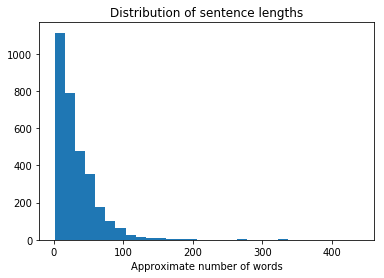

In [39]:
plt.hist([len(s.split()) for s in sentences], bins=30);
plt.title('Distribution of sentence lengths')
plt.xlabel('Approximate number of words');

The first few sentences detected by NLTK are too short to be considered real sentences. Let's have a look at short sentences with at least 20 characters:

In [40]:
sorted_sentences = sorted([s for s in sentences if len(s) > 20], key=len)
for s in sorted_sentences[:5]:
    print(s)

THE FREE SPIRIT   24.
Why Atheism nowadays?
Always the old story!
What binds strongest?
That has now changed.


Some long sentences:

In [41]:
for s in sorted_sentences[-3:]:
    print(s)

However gratefully one may welcome the OBJECTIVE spirit--and who has not been sick to death of all subjectivity and its confounded IPSISIMOSITY!--in the end, however, one must learn caution even with regard to one's gratitude, and put a stop to the exaggeration with which the unselfing and depersonalizing of the spirit has recently been celebrated, as if it were the goal in itself, as if it were salvation and glorification--as is especially accustomed to happen in the pessimist school, which has also in its turn good reasons for paying the highest honours to "disinterested knowledge" The objective man, who no longer curses and scolds like the pessimist, the IDEAL man of learning in whom the scientific instinct blossoms forth fully after a thousand complete and partial failures, is assuredly one of the most costly instruments that exist, but his place is in the hand of one who is more powerful He is only an instrument, we may say, he is a MIRROR--he is no "purpose in himself" The object

The NLTK sentence tokenizer seems to do a reasonable job despite the weird casing and '--' signs scattered around the text.

Note that here we use the original case information because it can help the NLTK sentence boundary detection model make better split decisions. Our text corpus is probably too small to train a good sentence aware language model though, especially with full case information. Using larger corpora such as a large collection of [public domain books](http://www.gutenberg.org/) or Wikipedia dumps. The NLTK toolkit also comes from [corpus loading utilities](http://www.nltk.org/book/ch02.html).

The following loads a selection of famous books from the Gutenberg project archive:

In [42]:
import nltk

nltk.download('gutenberg')
book_selection_text = nltk.corpus.gutenberg.raw().replace("\n", " ")

[nltk_data] Downloading package gutenberg to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [43]:
print(book_selection_text[:300])

[Emma by Jane Austen 1816]  VOLUME I  CHAPTER I   Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her.  She was t


In [44]:
print("Book corpus length: %d characters" % len(book_selection_text))

Book corpus length: 11793318 characters


Let's do an arbitrary split. Note the training set will have a majority of text that is not authored by the author(s) of the validation set:

In [45]:
split = int(0.9 * len(book_selection_text))
book_selection_train = book_selection_text[:split]
book_selection_validation = book_selection_text[split:]

## Bonus exercises

- Adapt the previous language model to handle explicitly sentence boundaries with a special EOS character.
- Train a new model on the random sentences sampled from the the book selection corpus with full case information.
- Adapt the random sampling code to start sampling at the beginning of sentence and stop when the sentence ends.
- Train a deep GRU (e.g. two GRU layers instead of a single LSTM) to see if you can improve the validation perplexity.
- Git clone the source code of the [Linux kernel](https://github.com/torvalds/linux) and train a C programming language model on it. Instead of sentence boundary markers, we could use source file boundary markers for this exercise. Compare your resutls with Andrej Karpathy's https://karpathy.github.io/2015/05/21/rnn-effectiveness/.
- Try to increase the vocabulary size to 256 using a [Byte Pair Encoding](https://arxiv.org/abs/1508.07909) strategy.

## Why build a language model?

Building a language model is not very useful by it-self. However language models have recently been shown to be useful for **transfer learning** to build **contextualized word embeddings** as a better alternative to word2vec or GloVe.

Using language-model based word representations makes it possible to reach the **state-of-the-art at many natural language understanding problems**.

The workflow is the following:

- **train** a (bi-directional) **deep language model on a very large, unlabeled corpus** (e.g. 1 billion words or more);
- plug the resulting **language model as the input layer** (and sometimes also the output layer) **of a task specific architecture**, for instance: text classification, semantic role labeling for knowledge extraction, logical entailment, question answering and reading comprehension;
- **train the task specific parameters** of the new architecure on the **smaller task-labeled corpus**;
- optionally fine-tune the full architecture on the task-labeled corpus if it's big enough not to overfit.

More information on this approach:

- Deep contextualized word representations, https://arxiv.org/abs/1802.05365
- [Pytorch implementation of ELMo](https://github.com/allenai/allennlp/blob/master/allennlp/modules/elmo.py) as part of the AllenNLP project: https://github.com/allenai/allennlp
- Fine-tuned Language Models for Text Classification https://arxiv.org/abs/1801.06146 (FitLaM)